In [3]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [4]:
DEBUG = True # don't save figures

In [47]:
results_path = ["prelim_exp_results/10train90run", "prelim_exp_results/50train50run"]
results_file = ["sim_results.pkl", "sim_results.pkl"]
environment_file = ["sim_environment.pkl", "sim_environment.pkl"]
diagnostics_file = ["sim_diagnostics.pkl", "sim_diagnostics.pkl"]

results = merge_results(results_path, results_file)
print("# metrics =", len(results.keys()))
print(results.keys(), "\n")

hyper_params = {
    "drift":[0.05, 0.1], 
    "attention_exp":[-0.2, -0.8], 
    "repeated_training":[0, 1], 
    "num_attrs":[15,20], 
    "num_clusters":[15,20],
    "compute_embeddings_via_surprise":[0],
    "create_cluster_user_pairs_by_user_topic_mapping":[1]
}

model_params = dict()
for p in itertools.product(*hyper_params.values()):
    model_params[f"{p[0]}drift_{p[1]}attention_{p[2]}retraining_{p[3]}attributes_{p[4]}clusters_{p[5]}surprise_{p[6]}user-topic-mapping"] = dict(zip(hyper_params.keys(), p))

model_keys = results['mse'].keys()
print("# models =", len(model_keys))
print(model_keys, "\n")

id_to_readable = dict(zip(model_keys, [key[:-len("0surprise_1user-topic-mapping")-1] for key in model_keys]))
print(id_to_readable)

# metrics = 14
dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'recall', 'rmse']) 

# models = 32
dict_keys(['0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_15attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_20clusters_0surprise_1user-t

In [95]:
y_labels = dict([
    ("mse", "mse"), 
    ("interaction_spread", "interaction spread"), 
    ("global_interaction_similarity", "average jacard similarity"), 
    ("inter_cluster_interaction_similarity", "average jacard similarity"), 
    ("intra_cluster_interaction_similarity", "average jacard similarity"), 
    ("mean_global_cosine_sim", "average cosine sim"),
    ("mean_intra_cluster_cosine_sim", "average cosine sim"),
    ("mean_inter_cluster_cosine_sim", "average cosine sim"),
    ("mean_cosine_sim_per_cluster", "average cosine sim"),
    ("mean_cluster_distance_from_centroid", "distance"),
    ("mean_global_distance_from_centroid", "distance"),
    ("mean_distance_from_centroid_per_cluster", "distance"),
    ("interaction_measurement", "No. interactions per item"),
    ("recall", "recall"),
    ("rmse", "rmse")
])

hyper_params = {
    "drift":[0.05, 0.1], 
    "attention_exp":[-0.2, -0.8], 
    "repeated_training":[0, 1], 
    "num_attrs":[15,20], 
    "num_clusters":[15,20],
    "compute_embeddings_via_surprise":[0],
    "create_cluster_user_pairs_by_user_topic_mapping":[1]
}

model_keys_grouped_by = {k: defaultdict(list) for k in hyper_params.keys()}
for model_name, param_dict in model_params.items():
    for param, value in param_dict.items():
        model_keys_grouped_by[param][value].append(model_name)

In [249]:
def graph_averaged_metric_by_axis(ax, train_results, metric_key, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, graph_by="params", mean_range=10, print_num_vals=0, legend=0):
    values = None
    for m in model_keys:
        # print(m)
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        if values is None:
            values = train_results[metric_key][m]
        else:
            values = np.vstack((values, train_results[metric_key][m]))
    mean_values = values.mean(axis=0)
    
    print(metric_key, "{0:.5f}".format(mean_values[-1:-mean_range:-1].mean()))
    if print_num_vals:
        print(mean_values[-1:-mean_range:-1])
        
    if legend:
        ax.plot(mean_values, label=metric_key)
        # ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5))
    else:
        ax.plot(mean_values)
    return ax

In [415]:
# Which hyper-param to graph by
# graph_by_hyper_param = "repeated_training"
# graph_by_hyper_param = "drift"
# graph_by_hyper_param = "attention_exp"
# graph_by_hyper_param = "num_attrs"
graph_by_hyper_param = "num_clusters"

# metric_key = "mse"
# metric_key = "interaction_spread"
# metric_key = "recall"
metric_key = "rmse"

variables = (graph_by_hyper_param, metric_key)

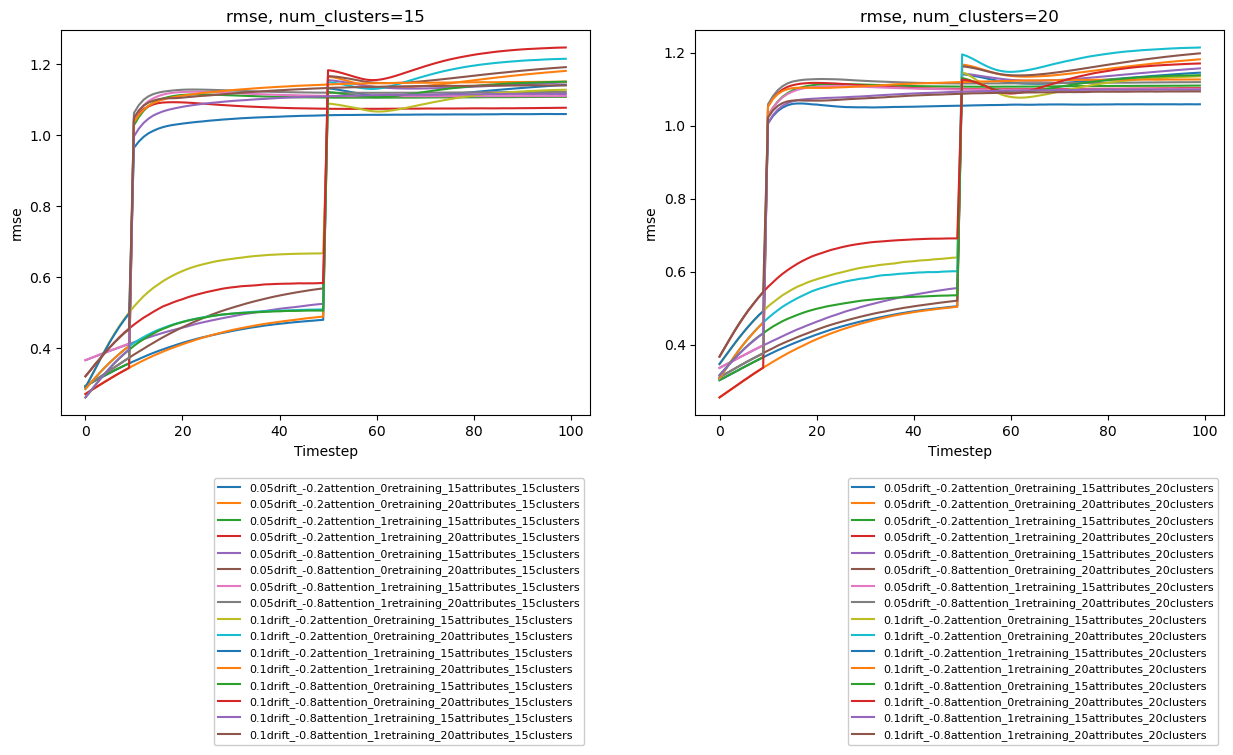

In [416]:
hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    graph_metrics_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"{metric_key}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)


num_clusters=15
rmse 1.12821

num_clusters=20
rmse 1.12012


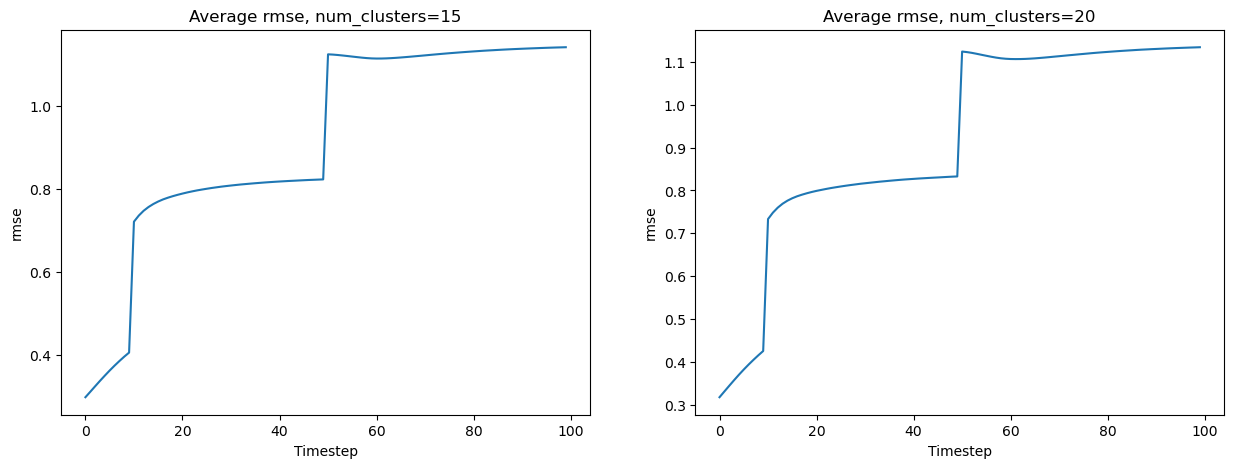

In [417]:
hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, mean_range=50)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {metric_key}, {graph_by_hyper_param}={param_val}")

## `Cosine similarity`


num_clusters=15
mean_intra_cluster_cosine_sim 0.67988
mean_global_cosine_sim 0.67969
mean_inter_cluster_cosine_sim 0.66363

num_clusters=20
mean_intra_cluster_cosine_sim 0.68722
mean_global_cosine_sim 0.68784
mean_inter_cluster_cosine_sim 0.68908

diff= 0.01625
normalized diff= 0.02390

diff= -0.00186
normalized diff= -0.00271


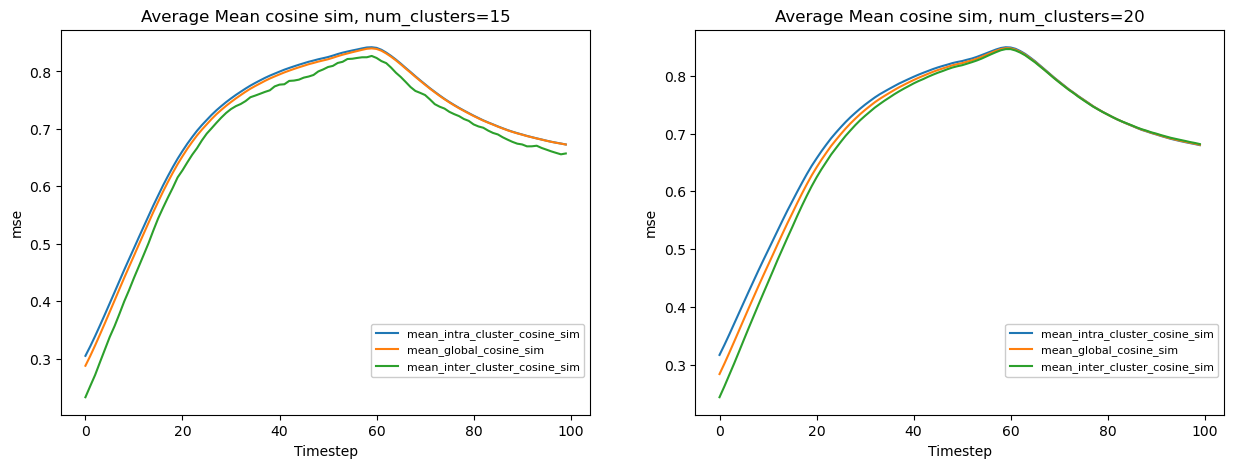

In [406]:
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

## `Interaction similarity`


num_clusters=15
intra_cluster_interaction_similarity 0.04763
global_interaction_similarity 0.04722
inter_cluster_interaction_similarity 0.04625

num_clusters=20
intra_cluster_interaction_similarity 0.04563
global_interaction_similarity 0.04519
inter_cluster_interaction_similarity 0.04466

diff= 0.00138
normalized diff= 0.02897

diff= 0.00097
normalized diff= 0.02126


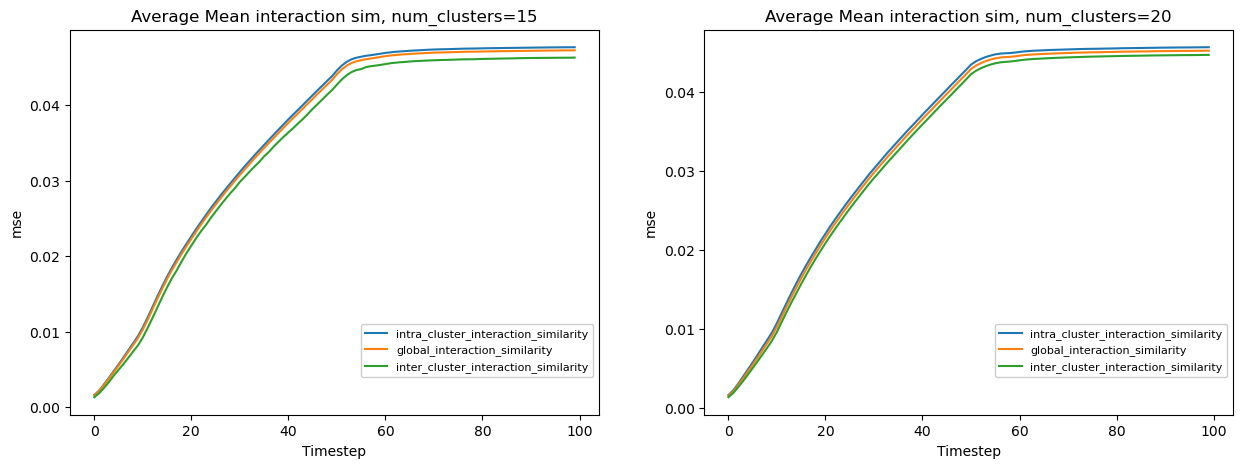

In [407]:
title = "Mean interaction sim"
metric_keys = ["intra_cluster_interaction_similarity", "global_interaction_similarity", "inter_cluster_interaction_similarity"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

## `Centroid distance`


num_clusters=15
mean_global_distance_from_centroid 1.06857
mean_cluster_distance_from_centroid 0.75892

num_clusters=20
mean_global_distance_from_centroid 0.99534
mean_cluster_distance_from_centroid 0.72854

diff= 0.30965
normalized diff= 0.28978

diff= 0.26680
normalized diff= 0.26805


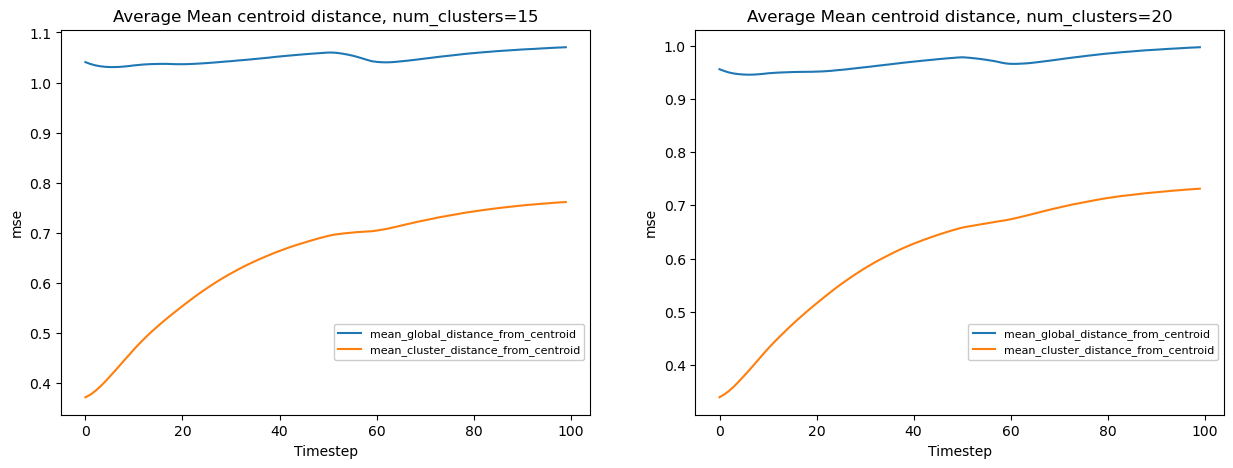

In [408]:
title = "Mean centroid distance"
metric_keys = ["mean_global_distance_from_centroid", "mean_cluster_distance_from_centroid"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)